# AR Modelling of EEG Data

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/chb01/'

In [49]:
# Summary
# File Name: chb01_03.edf
# File Start Time: 13:43:04
# File End Time: 14:43:04
# Number of Seizures in File: 1
# Seizure Start Time: 2996 seconds
# Seizure End Time: 3036 seconds
raw = mne.io.read_raw_edf(input_fname=os.path.join(root, os.listdir(root)[3]), preload=False, verbose='Error')
ch_names = raw.info['ch_names'] # array of channel names
EEG, times = raw.copy().get_data(picks=['eeg'], units='uV', return_times=True)
seizure_start_time = 2996
seizure_start_index = raw.time_as_index(seizure_time)
print(EEG.shape)

(23, 921600)


Initially, we model only a single channel EEG signal with AR(5).

In [91]:
fs = raw.info['sfreq']   # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 5                  # AR model order
t_s = 1/fs               # Input signal time period

print(f'AR({n_i})')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')

AR(5)
Window size: 512
Sampling frequency: 256.0 Hz
Prediction frequency: 0.5 Hz


In [92]:
%%time
np.random.seed(42)
n_samples = EEG[0,:].shape[0]                  # Length of input signal
e = EEG[0,:]                                   # Feed input signal
print('Input dim:', e.shape)
a = 1.8 * np.random.randn(n_i) - 0.9           # Initialise AR coefficients
a = a.reshape(-1,1)
Ik = N                                         # Window size
ar_index_list = []
ar_hats_list = []
for t in range(Ik + n_i, n_samples):           # Moving window starting from index 1 to (n_samples-1)
    window_start = t - Ik - n_i + 1
    window_end = t                             # Assume window_end is present time
    x_t = e[window_start:window_end]           # Select input sequence in window
    N_window = len(x_t)                        # Window size
    
    if t % N == 0:                             # Compute AR coefficients once every N samples
        ar_index_list.append(t)
        phi = x_t[N_window-n_i:N_window]
        phi = phi.reshape(-1,1)
        x_t = phi.T @ a
        ar_hat_window = np.linalg.pinv(phi@phi.T) @ (phi@x_t) # Least-squares
        ar_hats_list.append(ar_hat_window)
ar_index = np.array(ar_index_list)
ar_hats = np.array(ar_hats_list).squeeze()
print('Output dim:', ar_index.shape)

Input dim: (921600,)
Output dim: (1798,)
CPU times: user 879 ms, sys: 12 ms, total: 891 ms
Wall time: 954 ms


In [93]:
y_hat = np.zeros(len(ar_index))
for i in range(n_i, len(ar_index)):
    y_hat[i] = e[i]
    for j in range(n_i):
        y_hat[i] = y_hat[i] + ar_hats[i,j].reshape(-1,1) * y_hat[i-1]

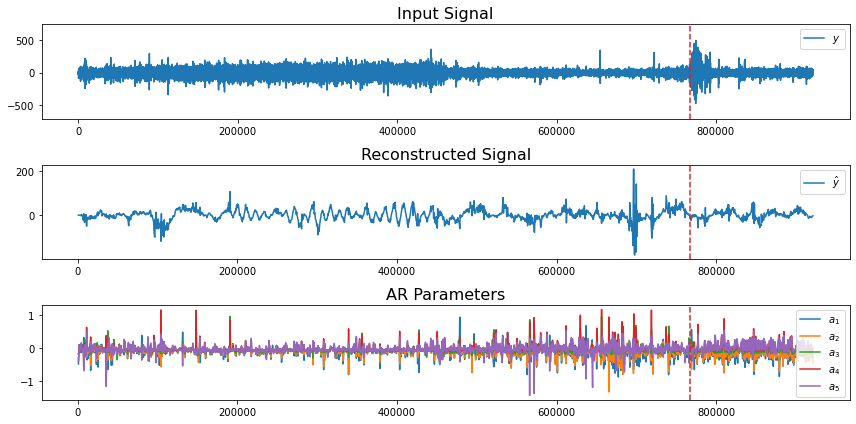

In [94]:
fig, axes = plt.subplots(figsize=(12,6), nrows=3)
axes[0].plot(np.arange(0, n_samples), e, label=r'$y$')
axes[0].axvline(x=seizure_start_index, color='tab:red', ls='--') # mark seizure onset
axes[0].set_ylim([e.min()*1.5, e.max()*1.5])
axes[0].legend(loc=1)
axes[0].set_title('Input Signal', fontsize=16) # input signal

axes[1].plot(ar_index, y_hat, label=r'$\hat{y}$')
axes[1].axvline(x=seizure_start_index, color='tab:red', ls='--')
# axes[1].set_ylim([e.min()*1.5, e.max()*1.5])
axes[1].legend(loc=1)
axes[1].set_title('Reconstructed Signal', fontsize=16)

for i in range(n_i):
    axes[2].plot(ar_index, ar_hats[:,i], label=f'$a_{i+1}$') # AR parameters varying
# axes[2].set_ylim([ar_hats.min(axis=0).min()*1.5, ar_hats.max(axis=0).max()*5.5])
axes[2].axvline(x=seizure_start_index, color='tab:red', ls='--')
axes[2].legend(loc=1)
axes[2].set_title('AR Parameters', fontsize=16)


plt.tight_layout()
plt.show()